<a href="https://colab.research.google.com/github/delaykimm/COSE461-NLP/blob/main/nlp_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install Keras-Preprocessing
import torch

from transformers import BertTokenizer, RobertaTokenizer
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.4 MB/s eta 0:00:00


## 1.1 Dataset

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# 파일 경로 설정
train_path = '/content/drive/My Drive/crawling_everytime.csv'
test_path = '/content/drive/My Drive/everytime_Korean.csv'

# 데이터 로드
train_dataset = pd.read_csv(train_path)
test_dataset = pd.read_csv(test_path)

train_dataset = train_dataset[["text", "label"]]
test_dataset = test_dataset.rename(columns={"tweet": "text"})
#print(test_dataset)
test_dataset = test_dataset[["text", "label"]]

#train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

print(train_dataset.shape)
print(test_dataset.shape)

Mounted at /content/drive
(14715, 2)
(1000, 2)


- 총 15만개의 train set과 5만개의 test set으로 이루어짐.
- 데이터의 형태를 살펴보기

In [3]:
# train.document 와 train.label만 사용
# label -> 0이면 negative, 1이면 positive. label을 맞춰야 하는 것
train_dataset.tail(10)
test_dataset.tail(10)

,text,label
990,아이폰처럼 사진 지웟던거 다시 복구하는 기능 있나요?,0
991,그냥 어느 순간 우울하다가 숨이 잘 안 쉬어지더니 계속해서 큰 숨을 들이쉬고 내쉬고...,1
992,"죽고싶지는 않아. 물론 죽는 게 무섭기도 한데, 그게 아니어도 죽고싶진 않아. 그냥...",1
993,여친한테 맘 좀 식었는데도\n나중에 우리 결혼해서 귀여운 애기낳고 살자 라고 말할 ...,0
994,아쉽다.. 은행나무 말고 살구나무가 이겼으면.. 학교에서 살구 막 따먹었을텐데..,0
995,이거 때문에 상대방이랑 헤어지고 싶거든 너무 지치고 내가 문제인걸 잘 알아서.. 근...,0
996,실수가 많았던 날들이었다\n그 사실들이 조금씩 따갑다\n그건 좋은 경험이라고 하기 ...,1
997,여자들 요새 남자 외모 많이 보잖아 근데 남자는 원래부터 여자 외모 많이 봤잖아 그...,0
998,누가 자꾸 내 머릿속에서 죽으라고 소리질러. 이거 닥치게 하는 방법 아는 사람? 팁...,1
999,사실 분 있을까요??,0


In [12]:
import matplotlib.pyplot as plt

# 각 데이터의 문장 수 계산
test_dataset['sentence_count'] = test_dataset['text'].apply(lambda x: len(x.split('. ')) - 1)

max_sentence_count = test_dataset['sentence_count'].max()
longest_text = test_dataset[test_dataset['sentence_count'] == max_sentence_count]['text'].iloc[0]

print(longest_text)

# 문장 개수가 가장 많은 데이터의 길이 출력
print("The maximum number of sentences in any text is:", max_sentence_count)

# # 문장 수 분포 시각화
# plt.figure(figsize=(10, 6))
# plt.hist(train_dataset['sentence_count'], bins=range(train_dataset['sentence_count'].max() + 2), edgecolor='black', align='left')
# plt.xlabel('Number of Sentences')
# plt.ylabel('Frequency')
# plt.title('Distribution of Sentence Counts in Text Data')
# plt.xticks(range(train_dataset['sentence_count'].max() + 1))
# plt.grid(axis='y')

# 시각화 출력
plt.show()

나는 병적인 우울증에서 빠져나온지 얼마 안 됐다. 중학교 때 자살 시도를 할 정도로 정말 심하게 왔고 그대로 계속 갔다. 고등학생 때도 정말 힘들었다. 관련 책, 영상 정말 많이 찾아봤다. 우울증이 너무 깊어지면 병의 삶을 살게 되면 정말 힘들다는 의사 말이 있는데 나는 그런 삶을 살았다. 우울증이 삶 자체가 되어버렸었다. 이건 나의 기질 때문인 것 같다. 나는 신경증적이고 예민한 사람이다. 그리고 어설프게 착한 사람이었던 것 같다. 세상을 혹독한 곳으로 봤다. 강해져야 하고 스스로를 지켜야 한다는 감각으로 살았던 것 같다. 사실 대학 합격만 하고 자살하려고 했다. 그런데 또 그냥 살게 되었다. 고통스러워 하면서. 올해 초반까지 정말 심각했다. 새내기 생활을 즐기지 못했음은 물론이다. 스스로가 이상하고 내면이 썩어있다는 생각과 밖으로 보이면 안된다는 생각이 있으니 사람을 만나서 멀쩡해보여야 한다는 생각과 함께 드러날 거라는 두려움으로 사람 만나는 게 너무 무서웠다. 그 생각이 너무 심해져서 강의실에서 강의 듣는 것조차도 너무 힘겨웠다. 처음으로 공황을 겪었다. 내 존재 자체가 남에게 폐가 될 거라고 생각했다. 조과제만 끝난 다음 기말 시험은 출석하지 않았다. 발표 수업은 던져 버렸다. 남들 앞에 서기가 죽도록 무서웠다. 갈데까지 갔구나란 생각이 들었다. 수업을 놓았다. 시험도 과제도. 학점은 바닥을 쳤다. 이 세상의 바닥에 혼자만이 남아있는 기분이었다. 그리고 거기서도 나는 더 바닥에 스스로를 묻지 못해 안달이었다. 그대로 땅에 묻히길 바랐다. 나는 답을 작성할 수 없었다. 시험지에도, 인생에도. 아무것도 할 수 없다는 무력감. 지금 생각해보면 나는 많이 아팠구나라는 생각이 든다. 그런데도 스스로를 할퀴기 바빴음을 생각하면 정말 안타깝다. 예전을 생각해보면 정신병은 맞던 것 같다. 멀쩡한 척 사느냐고 고생했다. 수고했다. 불완전하고 여기저기 구멍나있는 나로 살아가려고 한다. 스스로를 받아주려고 하는데 지금껏 내가 무너뜨리고 손도 대지 않고 포기한 것들은 너무 

## 1.2 Preprocessing
- BERT 모델에서 사용될 수 있는 형태로 변형


In [ ]:
# 리뷰 문장 추출
# sentences = train['document']
sentences = train_dataset.text
sentences[:10]

0    눈을 감았다 뜨면딱오직 별과 땅과 나평화로운 암흑은 빈틈을 채우고포근한 낮잠처럼 휘...
1    숨만 붙어있는 채로 졸업만 무사히 하고다음 일은 다음에 생각하자고 다짐했는데살아있는...
2    https://everytime.kr/396631/v/301432934이거 적은 사...
3    또 나 때문에 관계가 망가진 것 같고 그냥 다 그만두고, 아무도 모르는 곳으로 떠나...
4    언제부터 우울했어? 난 중2, 3 때 시작해서 고등학교 다니는 게 정말 힘들었어… ...
5    친구 없는 아싸는 아닌데과 분위기가 너무 안 맞아...왜들 그렇게 무리 못 지어서 ...
6    23살 남잔데, 잘생긴 사람들 보면 너무 부럽다. 얼굴이 잘생기지 않았어도 옷 입었...
7                                하루종일 누워 있음.. 다 의미가 없어
8    1. 평범하게 가족 외식하고 있는데 불안해서 손 떰2. 20분이상 공부 아예 안 됨...
9                                      입원해보신 분 계신가요???
Name: text, dtype: object

<p align="center">
  <img src="https://mino-park7.github.io/images/2019/02/bert-input-representation.png"/>
</p>


BERT의 입력은 위의 그림과 같은 형식입니다. Classification을 뜻하는 [CLS] Token이 제일 앞에 삽입됩니다. Fine-Tuning시 출력에서 이 CLS token을 사용하여 분류를 합니다. [SEP] token은 Seperation을 가리키는데, 두 문장을 구분하는 역할을 합니다. 지금 저희가 다루는 dataset은 문장이 sample당 하나이므로 문장의 끝에 [SEP] token을 더해줍니다.
<br>
<br>
<br>

In [ ]:
# BERT의 입력 형식에 맞게 변환. CLS와 SEP 토큰 붙여줘야 함
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] 눈을 감았다 뜨면딱오직 별과 땅과 나평화로운 암흑은 빈틈을 채우고포근한 낮잠처럼 휘감아,우리는 어디서 와 어디로 가는 걸까바랄 수 없는 어둠을 바라본다빛은 희망을 줄 정도면 충분한 것나에게는 태양이 필 [SEP]',
 '[CLS] 숨만 붙어있는 채로 졸업만 무사히 하고다음 일은 다음에 생각하자고 다짐했는데살아있는 것 조차 벅차네요 [SEP]',
 '[CLS] https://everytime.kr/396631/v/301432934이거 적은 사람인데 아직도 스크랩수가 올라간다 작년 5월에 쓴 글인데도오래전 글이라서 찾기도 힘들텐데 어떻게든 스크롤을 내려서 정신과에 대한 정보를 찾고자하는 사람들이 많구나 얼마나 힘들면 그럴까 [SEP]',
 '[CLS] 또 나 때문에 관계가 망가진 것 같고 그냥 다 그만두고, 아무도 모르는 곳으로 떠나고싶고, 근데 그럴바엔 그냥 죽고싶다 [SEP]',
 '[CLS] 언제부터 우울했어? 난 중2, 3 때 시작해서 고등학교 다니는 게 정말 힘들었어… 우울만 있는 건 아니고 불안도 갈수록 심해져서 막판에는 평가원 모의고사 보다가 극심한 불안으로 포기하고 집에 가서 엄청 울었어그러면서도 입시는 포기하고 싶지 않아서 이런 상태로 성공한 사례를 막 [SEP]',
 '[CLS] 친구 없는 아싸는 아닌데과 분위기가 너무 안 맞아...왜들 그렇게 무리 못 지어서 안달이야?진짜 죽어버려도 신경 하나도 안 쓸 거 같아 [SEP]',
 '[CLS] 23살 남잔데, 잘생긴 사람들 보면 너무 부럽다. 얼굴이 잘생기지 않았어도 옷 입었을 때, 비율이 좋은 사람들도 부러워. 난 진짜 앞에 말한거에서 아무것도 해당안됨. 유튜브 보면서 렌즈도 껴보고, 피부과도 가보고, 헬스도 다니고, 옷이나 신발도 좋은거 사보지만, 결국 빈털털이 [SEP]',
 '[CLS] 하루종일 누워 있음.. 다 의미가 없어 [SEP]',
 '[CLS] 1. 평범하게 가족 외식하고 있는데 불안해서 손 떰2. 20분이상 공부 아예 안 됨 두통과 함께 약한 브레인포그3. 청각이 과

- Tokenize
Tokenize를 위해 tokenize method를 사용하면 됩니다.

- BERT는 형태소분석으로 토큰을 분리하지 않습니다. WordPiece라는 통계적인 방식을 사용합니다. 한 단어내에서 자주 나오는 글자들을 붙여서 하나의 토큰으로 만듭니다. 이렇게 하면 언어에 상관없이 토큰을 생성할 수 있다는 장점이 있습니다. 또한 신조어 같이 사전에 없는 단어를 처리하기도 좋습니다.

- 아래의 결과에서 ## 기호는 앞 토큰과 이어진다는 표시입니다. 토크나이저는 여러 언어의 데이터를 기반으로 만든 'bert-base-multilingual-cased'를 사용합니다. 그래서 한글도 처리가 가능합니다.
<br>

In [ ]:
from transformers import AutoTokenizer
from transformers import ElectraTokenizer

# KC-ELECTRA 모델의 토크나이저 초기화
tokenizer2 = AutoTokenizer.from_pretrained('beomi/KcELECTRA-base-v2022')
tokens2 = tokenizer2.tokenize(sentences[0])

# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokens = tokenizer.tokenize(sentences[0])

# Roberta 모델의 토크나이저 초기화
tokenizer3 = AutoTokenizer.from_pretrained('klue/roberta-base')
tokens3 = tokenizer3.tokenize(sentences[0])

# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer4 = BertTokenizer.from_pretrained('kykim/bert-kor-base', do_lower_case=False)
tokens4 = tokenizer4.tokenize(sentences[0])

tokenizer5 = ElectraTokenizer.from_pretrained('monologg/koelectra-base-v3-discriminator', do_lower_case = False)
tokens5 = tokenizer5.tokenize(sentences[0])

print(tokens)
print(tokens2)
print(tokens3)
print(tokens4)
print(tokens5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/450k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/344k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

['[CLS]', '눈', '##을', '감', '##았다', '뜨', '##면', '##딱', '##오', '##직', '별', '##과', '땅', '##과', '나', '##평', '##화', '##로', '##운', '암', '##흑', '##은', '빈', '##틈', '##을', '채', '##우', '##고', '##포', '##근', '##한', '낮', '##잠', '##처럼', '휘', '##감', '##아', ',', '우', '##리는', '어', '##디', '##서', '와', '어', '##디', '##로', '가', '##는', '걸', '##까', '##바', '##랄', '수', '없는', '어', '##둠', '##을', '바', '##라', '##본', '##다', '##빛', '##은', '희', '##망', '##을', '줄', '정도', '##면', '충', '##분', '##한', '것', '##나', '##에게', '##는', '태', '##양', '##이', '필', '[SEP]']
['[CLS]', '눈을', '감', '##았다', '뜨면', '##딱', '##오', '##직', '별', '##과', '땅', '##과', '나', '##평화', '##로운', '암흑', '##은', '빈틈', '##을', '채우고', '##포', '##근', '##한', '낮잠', '##처럼', '휘감', '##아', ',', '우리는', '어디서', '와', '어디로', '가는', '걸까', '##바', '##랄', '수', '없는', '어둠', '##을', '바라본다', '##빛', '##은', '희망을', '줄', '정도면', '충분한', '것', '##나', '##에게는', '태양', '##이', '필', '[SEP]']
['[CLS]', '눈', '##을', '감', '##았', '##다', '뜨', '##면', '##딱', '##오', '##직', '별', '##과', '땅', '##과', '나', '##평', '##화

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
tokenized_texts2 = [tokenizer2.tokenize(sent) for sent in sentences]
tokenized_texts3 = [tokenizer3.tokenize(sent) for sent in sentences]
tokenized_texts4 = [tokenizer4.tokenize(sent) for sent in sentences]
tokenized_texts5 = [tokenizer5.tokenize(sent) for sent in sentences]

print(sentences[0])
print(tokenized_texts[0])
print(tokenized_texts2[0])
print(tokenized_texts3[0])
print(tokenized_texts4[0])
print(tokenized_texts5[0])

[CLS] 눈을 감았다 뜨면딱오직 별과 땅과 나평화로운 암흑은 빈틈을 채우고포근한 낮잠처럼 휘감아,우리는 어디서 와 어디로 가는 걸까바랄 수 없는 어둠을 바라본다빛은 희망을 줄 정도면 충분한 것나에게는 태양이 필 [SEP]
['[CLS]', '눈', '##을', '감', '##았다', '뜨', '##면', '##딱', '##오', '##직', '별', '##과', '땅', '##과', '나', '##평', '##화', '##로', '##운', '암', '##흑', '##은', '빈', '##틈', '##을', '채', '##우', '##고', '##포', '##근', '##한', '낮', '##잠', '##처럼', '휘', '##감', '##아', ',', '우', '##리는', '어', '##디', '##서', '와', '어', '##디', '##로', '가', '##는', '걸', '##까', '##바', '##랄', '수', '없는', '어', '##둠', '##을', '바', '##라', '##본', '##다', '##빛', '##은', '희', '##망', '##을', '줄', '정도', '##면', '충', '##분', '##한', '것', '##나', '##에게', '##는', '태', '##양', '##이', '필', '[SEP]']
['[CLS]', '눈을', '감', '##았다', '뜨면', '##딱', '##오', '##직', '별', '##과', '땅', '##과', '나', '##평화', '##로운', '암흑', '##은', '빈틈', '##을', '채우고', '##포', '##근', '##한', '낮잠', '##처럼', '휘감', '##아', ',', '우리는', '어디서', '와', '어디로', '가는', '걸까', '##바', '##랄', '수', '없는', '어둠', '##을', '바라본다', '##빛', '##은', '희망을', '줄', '정도면', '충분한', '것', '##나', '##에게는', '태양', '##이', '필'

- 이런 토큰들을 인덱스로 변경하려면 tokenizer.convert_tokens_to_ids method를 이용하시면 됩니다.

- 따라서 앞에서 토크나이즈 한 모든 문장을 word index로 변환해 줍니다.
- 다들 아시겠지만, 보통 딥러닝 모델에는 토큰 자체를 입력으로 넣을 수 없습니다. 임베딩 레이어에는 토큰을 숫자로 된 인덱스로 변환하여 사용합니다.

- 여기서 길이 맞춤 작업을 합니다.
- truncating은 max_len 기준으로 자르고, padding은 그 반대입니다.

In [ ]:
word2num = tokenizer.convert_tokens_to_ids(tokens) # Convert Tokens to the indices
word2num2 = tokenizer2.convert_tokens_to_ids(tokens2)
word2num3 = tokenizer3.convert_tokens_to_ids(tokens3)
word2num4 = tokenizer4.convert_tokens_to_ids(tokens4)
word2num5 = tokenizer5.convert_tokens_to_ids(tokens5)

print(word2num)
print(word2num2)
print(word2num3)
print(word2num4)
print(word2num5)

[101, 9034, 10622, 8848, 27303, 9151, 14867, 118826, 28188, 33077, 9353, 11882, 9136, 11882, 8982, 119398, 18227, 11261, 21614, 9526, 119461, 10892, 9381, 119374, 10622, 9738, 27355, 11664, 55530, 50248, 11102, 8992, 119198, 92383, 10010, 105197, 16985, 117, 9604, 26344, 9546, 48446, 12424, 9590, 9546, 48446, 11261, 8843, 11018, 8867, 118671, 42144, 118852, 9460, 40364, 9546, 118806, 10622, 9318, 17342, 40419, 11903, 119007, 10892, 10023, 89292, 10622, 9692, 107657, 14867, 9770, 37712, 11102, 8870, 16439, 26212, 11018, 9854, 37114, 10739, 9949, 102]
[2, 15063, 868, 8518, 33646, 4353, 4390, 4383, 1975, 4162, 1520, 4162, 1188, 17016, 9033, 42296, 4142, 43924, 4229, 26739, 4405, 4078, 4070, 46364, 8055, 49907, 4025, 16, 9418, 8731, 2596, 12044, 9101, 23683, 4096, 4521, 2279, 8059, 31715, 4229, 48631, 4864, 4142, 17595, 2851, 12043, 23138, 910, 4046, 10815, 11318, 4034, 3449, 3]
[0, 780, 2069, 548, 2886, 2062, 930, 2460, 2587, 2168, 2084, 1156, 2145, 903, 2145, 717, 2139, 2267, 6408, 15537

In [ ]:
# 입력 토큰의 최대 시퀀스 길이
max_len = 128

# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids2 = [tokenizer2.convert_tokens_to_ids(x) for x in tokenized_texts2]
input_ids3 = [tokenizer3.convert_tokens_to_ids(x) for x in tokenized_texts3]
input_ids4 = [tokenizer4.convert_tokens_to_ids(x) for x in tokenized_texts4]
input_ids5 = [tokenizer5.convert_tokens_to_ids(x) for x in tokenized_texts5]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움. 데이터 길이를 맞춰줌
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")
input_ids2 = pad_sequences(input_ids2, maxlen=max_len, dtype="long", truncating="post", padding="post")
input_ids3 = pad_sequences(input_ids3, maxlen=max_len, dtype="long", truncating="post", padding="post")
input_ids4 = pad_sequences(input_ids4, maxlen=max_len, dtype="long", truncating="post", padding="post")
input_ids5 = pad_sequences(input_ids5, maxlen=max_len, dtype="long", truncating="post", padding="post")

print(input_ids[0])
print(input_ids2[0])
print(input_ids3[0])
print(input_ids4[0])
print(input_ids5[0])

[   101   9034  10622   8848  27303   9151  14867 118826  28188  33077
   9353  11882   9136  11882   8982 119398  18227  11261  21614   9526
 119461  10892   9381 119374  10622   9738  27355  11664  55530  50248
  11102   8992 119198  92383  10010 105197  16985    117   9604  26344
   9546  48446  12424   9590   9546  48446  11261   8843  11018   8867
 118671  42144 118852   9460  40364   9546 118806  10622   9318  17342
  40419  11903 119007  10892  10023  89292  10622   9692 107657  14867
   9770  37712  11102   8870  16439  26212  11018   9854  37114  10739
   9949    102      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0]
[    2 15063   868  8518 33646  4353  4390  4383  1975  4162  1520  4162
  1188 17016  903

- padding 자리를 attention할 필요는 없기 때문에, 이를 방지하기 위해 padding 자리는 0, 그렇지 않으면 1의 값을 갖는 attention_masks를 만듭니다.

In [ ]:
# 어텐션 마스크 초기화
attention_masks = []
attention_masks2 = []
attention_masks3 = []
attention_masks4 = []
attention_masks5 = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정 -> 패딩 부분 모델에서 처리 안 하게 함
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

for seq in input_ids2:
    seq_mask = [float(i>0) for i in seq]
    attention_masks2.append(seq_mask)

for seq in input_ids3:
    seq_mask = [float(i>0) for i in seq]
    attention_masks3.append(seq_mask)

for seq in input_ids4:
    seq_mask = [float(i>0) for i in seq]
    attention_masks4.append(seq_mask)

for seq in input_ids5:
    seq_mask = [float(i>0) for i in seq]
    attention_masks5.append(seq_mask)

print(input_ids[0][:20])
print(input_ids2[0][:20])
print(input_ids3[0][:20])
print(input_ids4[0][:20])
print(input_ids5[0][:20])

print(attention_masks[0][:20])
print(attention_masks2[0][:20])
print(attention_masks3[0][:20])
print(attention_masks4[0][:20])
print(attention_masks5[0][:20])

[   101   9034  10622   8848  27303   9151  14867 118826  28188  33077
   9353  11882   9136  11882   8982 119398  18227  11261  21614   9526]
[    2 15063   868  8518 33646  4353  4390  4383  1975  4162  1520  4162
  1188 17016  9033 42296  4142 43924  4229 26739]
[    0   780  2069   548  2886  2062   930  2460  2587  2168  2084  1156
  2145   903  2145   717  2139  2267  6408 15537]
[    2 16703  2117 14127  3643  8043  8693  8122  8420  4462  8289  3458
  8289  2783 37147 14306 38151  8078 31104  8051]
[    2  2315  4292  2016  4494  4176  2506  4181  5136  4127  4497  2773
  4047  2466  4047  2236  4159  4162  9119 17183]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

- 따라서 위의 모든 과정을 train, test 모두에 반복적으로 해야하는 전처리 과정을 함수를 통해서 구현

In [ ]:
def preprocessing_bert(split):
  sentences = split.text
  # for bert
  sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
  tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

  max_len = 128
  # word2idx & padding
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")

  # 어텐션 마스크 초기화
  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  # labels
  labels = split.label.values

  return input_ids, attention_masks, labels

def preprocessing_kcelectra(split):
  sentences = split.text
  # for kcelectra
  sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
  tokenizer = AutoTokenizer.from_pretrained('beomi/KcELECTRA-base-v2022')
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

  max_len = 128
  # word2idx & padding
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")

  # 어텐션 마스크 초기화
  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  labels = split.label.values

  return input_ids, attention_masks, labels

def preprocessing_roberta(split):
  sentences = split.text
  # for roberta
  sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
  tokenizer = AutoTokenizer.from_pretrained('klue/roberta-base')
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

  max_len = 128
  # word2idx & padding
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")

  # 어텐션 마스크 초기화
  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  labels = split.label.values

  return input_ids, attention_masks, labels

def preprocessing_bertkor(split):
  sentences = split.text
  # for bert
  sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
  tokenizer = BertTokenizer.from_pretrained('kykim/bert-kor-base', do_lower_case=False)
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

  max_len = 128
  # word2idx & padding
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")

  # 어텐션 마스크 초기화
  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  # labels
  labels = split.label.values

  return input_ids, attention_masks, labels

def preprocessing_koelectra(split):
  sentences = split.text
  # for kcelectra
  sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
  tokenizer = AutoTokenizer.from_pretrained('monologg/koelectra-base-v3-discriminator')
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

  max_len = 128
  # word2idx & padding
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")

  # 어텐션 마스크 초기화
  attention_masks = []
  for seq in input_ids:
      seq_mask = [float(i>0) for i in seq]
      attention_masks.append(seq_mask)

  labels = split.label.values

  return input_ids, attention_masks, labels

#train_ids, train_att_masks, train_labels = preprocessing_bert(train_dataset)
train_ids, train_att_masks, train_labels = preprocessing_kcelectra(train_dataset)
#train_ids, train_att_masks, train_labels = preprocessing_roberta(train_dataset)
#train_ids, train_att_masks, train_labels = preprocessing_bertkor(train_dataset)
#train_ids, train_att_masks, train_labels = preprocessing_koelectra(train_dataset)

#test_ids, test_att_masks, test_labels = preprocessing_bert(test_dataset)
test_ids, test_att_masks, test_labels = preprocessing_kcelectra(test_dataset)
#test_ids, test_att_masks, test_labels = preprocessing_roberta(test_dataset)
#test_ids, test_att_masks, test_labels = preprocessing_bertkor(test_dataset)
#test_ids, test_att_masks, test_labels = preprocessing_koelectra(test_dataset)

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


### 딥러닝 패키지 [pytorch](https://tutorials.pytorch.kr/)

- train set의 일부를 validation set으로 나눔 (sklearn 활용)

In [ ]:
from sklearn.model_selection import train_test_split

# 훈련셋과 검증셋으로 분리
trn_inputs, val_inputs, trn_labels, val_labels = train_test_split(
    train_ids,
    train_labels,  # 라벨
    random_state=2021,
    test_size=0.2,
    stratify=train_labels  # 계층화 기준으로 라벨을 사용
)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
print(len(train_att_masks))

trn_masks, val_masks, _, _ = train_test_split(
    train_att_masks,
    train_labels,
    random_state=2021, test_size=0.2,
    stratify = train_labels)

# 데이터를 파이토치의 텐서로 변환
trn_inputs = torch.tensor(trn_inputs)
trn_labels = torch.tensor(trn_labels)
trn_masks = torch.tensor(trn_masks)

val_inputs = torch.tensor(val_inputs)
val_labels = torch.tensor(val_labels)
val_masks = torch.tensor(val_masks)

# 마찬가지로, test set도 텐서로 변환
test_inputs = torch.tensor(test_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_att_masks)


print("train inputs: ", trn_inputs[0])
print("valid inputs: ",val_inputs[0])
print("test inputs: ",test_ids[0])

14715
train inputs:  tensor([    2, 13108, 49518, 25400,    18,    18, 45246,  4105,  4554,  8326,
            3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 

In [ ]:
print("train labels: ", trn_labels[0])
print("valid labels: ",val_labels[0])
print("test labels: ",test_labels[0])

train labels:  tensor(0)
valid labels:  tensor(0)
test labels:  tensor(0)


In [ ]:
print("train masks: ", trn_masks[0])
print("valid masks: ",val_masks[0])
print("test masks: ",test_masks[0])

train masks:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
valid masks:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

## 1.3 Dataloader

- 파이토치에는 Dataset과 DataLoader라는 기능이 있어서 미니 배치 학습이나 데이터 셔플, 병렬 처리 까지 간단히 수행할 수 있습니다.
- TensorDataset은 Dataset을 상속한 클래스로 학습 데이터 X와 레이블 Y를 묶어 놓는 컨테이너 입니다.
- TensorDataset을 DataLoader에 전달하면 for 루프에서 데이터의 일부분만 간단히 추출할 수 있게 됩니다.
- TensorDataset에는 텐서만 전달할 수 있으며, Variable은 전달할 수 없습니다.
- Dataset은 직접 작성할 수도 있어서 대량의 이미지 파일을 한 번에 메모리에 저장하지 않고 필요할 때마다 읽어서 학습하는 등 다양하게 활용할 수 있습니다.

In [ ]:
# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
batch_size = 128 # 한 번에 모델에 올리는 수

trn_data = TensorDataset(trn_inputs, trn_masks, trn_labels)
trn_sampler = RandomSampler(trn_data)
trn_dataloader = DataLoader(trn_data, sampler=trn_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## 1.4 Modeling

Pre-trained BERT는 다양한 task로 Transfer learning이 가능합니다. 여기서는 위의 그림과 같이 한 문장을 분류하는 방법을 사용합니다. 영화리뷰 문장이 입력으로 들어가면, 긍정/부정으로 구분합니다. 모델의 출력에서 [CLS] 위치인 첫 번째 토큰에 새로운 레이어를 붙여서 fine-tuning을 합니다. Huggning Face는 BertForSequenceClassification() 함수를 제공하기 때문에 쉽게 구현할 수 있습니다.
<br>
<br>
<br>
![대체 텍스트](http://www.mccormickml.com/assets/BERT/padding_and_mask.png)


In [ ]:
# GPU를 위한 디바이스 설정
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

from transformers import ElectraForSequenceClassification

# 분류를 위한 BERT 모델 생성
#model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2) # pre-trained BERT 불러옴
#model = BertForSequenceClassification.from_pretrained("kykim/bert-kor-base", num_labels=2)
#model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels=2)

from transformers import AutoModelForSequenceClassification
from transformers import RobertaForSequenceClassification

# 모델 로드
#model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained('beomi/KcELECTRA-base-v2022', num_labels=2)
model.to(device) # load the model to the GPU

# out_features = 2: binery classification

There are 1 GPU(s) available.
We will use the GPU: NVIDIA L4


pytorch_model.bin:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
# 시간표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 정확도 계산 함수
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)


# 재현을 위해 랜덤시드 고정함수 -> seed 때문에 학습이 잘 됐다고 뜨는 건지 혼동 방지 위함
def set_seed(seed):
  seed_val = seed
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

### Scheduler

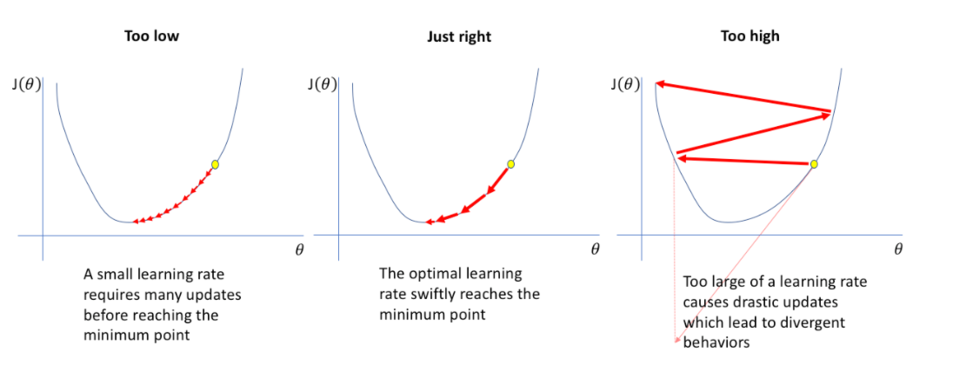

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
# 에폭수
epochs = 10
# 총 훈련 스텝 : 배치반복 횟수 * 에폭
total_steps = len(trn_dataloader) * epochs
# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
# random seed
seed = 2021
set_seed(seed)

# print_step
print_step = 100

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# !pip install wandb

In [ ]:
# import wandb
# wandb.login()

In [ ]:
# import wandb
# wandb.init(
#     # Set the project where this run will be logged
#     project="depression-detection",
#     # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
#     name=f"best",
#     # Track hyperparameters and run metadata
#     config={
#         "epochs": epochs,
#         "batch_size": trn_dataloader.batch_size,
#         "learning_rate": optimizer.defaults['lr'],
#         "optimizer": optimizer.__class__.__name__,
#         "scheduler": scheduler.__class__.__name__,
#     })

In [ ]:
import torch
import time
import numpy as np
from torch.nn.functional import softmax
from sklearn.metrics import f1_score, accuracy_score
import datetime

# Early Stopping 설정
early_stopping_patience = 5
best_val_loss = float('inf')
patience_counter = 0

embedding_vectors = []
labels_list = []
input_ids_list = []

def save_embedding_hook(module, input, output):
    embedding_vectors.append(output.detach().cpu().numpy())

def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 모델 임베딩 레이어에 hook 함수 등록
embedding_layer = model.electra.embeddings
hook = embedding_layer.register_forward_hook(save_embedding_hook)

# 학습 코드
model.zero_grad()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(trn_dataloader):
        if step % print_step == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(trn_dataloader), elapsed))

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.cpu().item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        model.zero_grad()

        # 임베딩과 레이블 저장
        labels_list.extend(b_labels.cpu().numpy())
        input_ids_list.extend(b_input_ids.cpu().numpy())

    avg_train_loss = total_loss / len(trn_dataloader)
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    print("Running Validation...")
    t0 = time.time()
    model.eval()
    eval_loss, eval_f1 = 0, 0
    nb_eval_steps = 0
    all_preds, all_labels = [], []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = softmax(outputs.logits, dim=-1)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 예측 클래스 추출
        preds = np.argmax(logits, axis=1)
        all_preds.extend(preds)
        all_labels.extend(label_ids)
        nb_eval_steps += 1

    # f1 score 계산
    eval_f1 = f1_score(all_labels, all_preds, average='weighted')
    eval_accuracy = accuracy_score(all_labels, all_preds)
    print("  Accuracy: {0:.5f}".format(eval_accuracy))
    print("  F1 Score: {0:.5f}".format(eval_f1))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

    # Early Stopping 체크
    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Hook 제거
hook.remove()

print("Training complete!")

======== Epoch 1 / 10 ========
Training...
  Average training loss: 0.31
  Training epoch took: 0:01:42
Running Validation...
  Accuracy: 0.93884
  F1 Score: 0.93890
  Validation took: 0:00:10
======== Epoch 2 / 10 ========
Training...
  Average training loss: 0.14
  Training epoch took: 0:01:44
Running Validation...
  Accuracy: 0.93612
  F1 Score: 0.93567
  Validation took: 0:00:10
======== Epoch 3 / 10 ========
Training...
  Average training loss: 0.09
  Training epoch took: 0:01:45
Running Validation...
  Accuracy: 0.94937
  F1 Score: 0.94926
  Validation took: 0:00:10
======== Epoch 4 / 10 ========
Training...
  Average training loss: 0.06
  Training epoch took: 0:01:45
Running Validation...
  Accuracy: 0.95277
  F1 Score: 0.95281
  Validation took: 0:00:10
======== Epoch 5 / 10 ========
Training...
  Average training loss: 0.04
  Training epoch took: 0:01:45
Running Validation...
  Accuracy: 0.94699
  F1 Score: 0.94681
  Validation took: 0:00:10
======== Epoch 6 / 10 ========
Trai

In [ ]:
# import torch
# import time
# from torch.nn.functional import softmax
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score

# embedding_vectors = []

# def save_embedding_hook(module, input, output):
#     embedding_vectors.append(output.detach().cpu().numpy())

# def format_time(elapsed):
#     # 반올림
#     elapsed_rounded = int(round((elapsed)))
#     # hh:mm:ss으로 형태 변경
#     return str(datetime.timedelta(seconds=elapsed_rounded))

# # WandB 초기화
# #wandb.init(project="depression_detection", entity="Roberta")
# # wandb.init()
# # wandb.config.update({
# #     "epochs": epochs,
# #     "batch_size": trn_dataloader.batch_size,
# #     "learning_rate": optimizer.defaults['lr'],
# #     "optimizer": optimizer.__class__.__name__,
# #     "scheduler": scheduler.__class__.__name__,
# # })

# # Early Stopping 설정
# early_stopping_patience = 5
# best_val_loss = float('inf')
# patience_counter = 0

# # 모델을 WandB에 로깅
# # wandb.watch(model, log="all")

# # 모델 임베딩 레이어에 hook 함수 등록
# embedding_layer = model.electra.embeddings
# hook = embedding_layer.register_forward_hook(save_embedding_hook)

# # 학습 코드
# model.zero_grad()

# for epoch_i in range(0, epochs):
#     print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
#     print('Training...')

#     t0 = time.time()
#     total_loss = 0
#     model.train()

#     for step, batch in enumerate(trn_dataloader):
#         if step % print_step == 0 and not step == 0:
#             elapsed = format_time(time.time() - t0)
#             print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(trn_dataloader), elapsed))

#         batch = tuple(t.to(device) for t in batch)
#         b_input_ids, b_input_mask, b_labels = batch
#         outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
#         loss = outputs[0]
#         total_loss += loss.cpu().item()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()
#         scheduler.step()
#         model.zero_grad()

#         # WandB에 학습 로스 기록
#         # wandb.log({"train_loss": loss.cpu().item()})

#     avg_train_loss = total_loss / len(trn_dataloader)
#     print("  Average training loss: {0:.2f}".format(avg_train_loss))
#     print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

#     # WandB에 학습 에폭 로스 기록
#     # wandb.log({"avg_train_loss": avg_train_loss, "epoch": epoch_i + 1})

#     print("Running Validation...")
#     t0 = time.time()
#     model.eval()
#     eval_loss, eval_f1 = 0, 0
#     nb_eval_steps = 0
#     all_preds, all_labels = [], []

#     for batch in val_dataloader:
#         batch = tuple(t.to(device) for t in batch)
#         b_input_ids, b_input_mask, b_labels = batch
#         with torch.no_grad():
#             outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
#         logits = softmax(outputs.logits, dim=-1)
#         logits = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()

#         # 예측 클래스 추출
#         preds = np.argmax(logits, axis=1)
#         all_preds.extend(preds)
#         all_labels.extend(label_ids)
#         nb_eval_steps += 1

#     # f1 score 계산
#     eval_f1 = f1_score(all_labels, all_preds, average='weighted')
#     eval_accuracy = accuracy_score(all_labels, all_preds)
#     print("  Accuracy: {0:.5f}".format(eval_accuracy))
#     print("  F1 Score: {0:.5f}".format(eval_f1))
#     print("  Validation took: {:}".format(format_time(time.time() - t0)))

#     # WandB에 검증 결과 기록
#     # wandb.log({
#     #     "val_f1": eval_f1,
#     #     "val_accuracy": eval_accuracy,
#     #     "epoch": epoch_i + 1
#     # })

#      # Early Stopping 체크
#     if eval_loss < best_val_loss:
#         best_val_loss = eval_loss
#         patience_counter = 0
#     else:
#         patience_counter += 1

#     if patience_counter >= early_stopping_patience:
#         print("Early stopping triggered.")
#         break

# # Hook 제거
# hook.remove()

# print("Training complete!")

In [ ]:
print("Doing test...")
t0 = time.time()
model.eval()
eval_loss, eval_f1 = 0, 0
nb_eval_steps = 0
all_preds, all_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = softmax(outputs.logits, dim=-1)
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 예측 클래스 추출
    preds = np.argmax(logits, axis=1)
    all_preds.extend(preds)
    all_labels.extend(label_ids)
    nb_eval_steps += 1

# f1 score 계산
eval_f1 = f1_score(all_labels, all_preds, average='weighted')
eval_accuracy = accuracy_score(all_labels, all_preds)
print("  Accuracy: {0:.5f}".format(eval_accuracy))
print("  F1 Score: {0:.5f}".format(eval_f1))
print("  Test took: {:}".format(format_time(time.time() - t0)))

# WandB에 테스트 결과 기록
# wandb.log({
#     "test_f1": eval_f1,
#     "test_accuracy": eval_accuracy
# })

#wandb.finish()

Doing test...
  Accuracy: 0.91800
  F1 Score: 0.91797
  Test took: 0:00:03


## 1.7 Inference new data

학습한 모델을 가지고 실제 문장을 넣어봤다. 0은 비우울, 1은 우울
<br>
<br>

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

results = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

text_data = ['내가 만든 언어 학습용 Chat gpt 한 번 써봐', '자살 시도했을 때 죽었어야 한다고 말해버렸어',
             '오늘 약간 울었어요 사실 많이요 나를 이해해주고 따뜻하게 말을 건네는 사람들을 내가 인생에서 밀어냈나 싶어서요',
             '다른 친구들처럼 되려고 노력해보려고 해도 잘 안 되고 어떻게 해야할지 모르겠고 그냥 다 답답해',
             '소개팅 24학번인데 저녁 식사 머가 좋을까염 치맥이나 파스타 정도면 되려나',
             '죽고싶어', '오늘 축제날이라 즐거워야 하는데 많이 울적해... 그냥 집 나가기 싫어',
             '씹 ㅋㅋㅋㅋ 오늘 어떤 멍청한 새끼 때문에 팀플 터짐 개빡치네',
             '오늘은 왠지 한강이 가고 싶은 날이다. 수온이 몇 도지?',
             '아 오늘 본 영화 개노잼이었어', "어제 늦게자서 그런지 피곤해. 요즘 과제가 많아서 막 정신도 없고",
             "오늘 교수님이 수업을 일찍 끝내주셔서서 강의실에서 뛰어나오다가 다른 사람 다리에 걸려넘어져서 무릎이 까졌어",
             "물 마시고 싶어", '내일 예비군이야...' , "내 나이 22살. 내일 입대네....",
             "...어쩐지 인기가요 뮤직뱅크 등등 음악방송만 죽도록 봤더니 아이돌 팬", "우울 만화 고민중인데 어떤게 맘에 듭네까",
             "내가 느끼기에도 난 너무 재미없는 사람 같아",
             "아ㅏ 피곤해ㅠㅠ", "나는 1.4km 전부터 거북이운전하면서 기다린 내부순환도로 출구에서 끼어드는 새끼들 올한해 모든 불행이 덮치길 기원",
             "속이 너무 울렁거린다..ㅠ", "나 결국 수료했어\n전공이 3.5도 안되는 점수라서 취업게시판에서는 자랑도 못하지만\n그래도 버텼어...!\n나혼자 칭찬해보고싶어서 그냥...",
             "넷플릭스나 드라마 재밌게 본 거 있어?"]

tokenized_texts = [tokenizer2.tokenize(sent) for sent in text_data]

max_len = 128
input_ids = [tokenizer2.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

inputs = torch.tensor(input_ids)
masks = torch.tensor(attention_masks)

inputs = inputs.to(device)
masks = masks.to(device)

with torch.no_grad():
    outputs = model(inputs,
                    token_type_ids=None,
                    attention_mask=masks)

    probabilities = softmax(outputs.logits, dim=-1)
    results.append(probabilities)
    print(probabilities)

# 각 텍스트 데이터에 대해 가장 큰 확률 값을 가진 label과 그 확률값을 출력하고 WandB에 기록
for i, prob in enumerate(probabilities):
    max_prob = torch.max(prob).item()
    max_label = torch.argmax(prob).item()
    text = text_data[i]

    print(f"Text: {text}")
    print(f"  Predicted Label: {max_label}, Probability: {max_prob:.5f}")

    # # WandB에 기록
    # wandb.log({
    #     f"text_{i+1}_predicted_label": max_label,
    #     f"text_{i+1}_probability": max_prob
    # })

#wandb.finish()

cuda
tensor([[0.9970, 0.0030],
        [0.0024, 0.9976],
        [0.0019, 0.9981],
        [0.0033, 0.9967],
        [0.9985, 0.0015],
        [0.0051, 0.9949],
        [0.0020, 0.9980],
        [0.9919, 0.0081],
        [0.0069, 0.9931],
        [0.9500, 0.0500],
        [0.0957, 0.9043],
        [0.3620, 0.6380],
        [0.3392, 0.6608],
        [0.3900, 0.6100],
        [0.0096, 0.9904],
        [0.9975, 0.0025],
        [0.9983, 0.0017],
        [0.0030, 0.9970],
        [0.7814, 0.2186],
        [0.9736, 0.0264],
        [0.9833, 0.0167],
        [0.0030, 0.9970],
        [0.1095, 0.8905]], device='cuda:0')
Text: 내가 만든 언어 학습용 Chat gpt 한 번 써봐
  Predicted Label: 0, Probability: 0.99704
Text: 자살 시도했을 때 죽었어야 한다고 말해버렸어
  Predicted Label: 1, Probability: 0.99763
Text: 오늘 약간 울었어요 사실 많이요 나를 이해해주고 따뜻하게 말을 건네는 사람들을 내가 인생에서 밀어냈나 싶어서요
  Predicted Label: 1, Probability: 0.99808
Text: 다른 친구들처럼 되려고 노력해보려고 해도 잘 안 되고 어떻게 해야할지 모르겠고 그냥 다 답답해
  Predicted Label: 1, Probability: 0.99671
Text: 소개팅 24학번

In [ ]:
# # 모델 저장 디렉토리 설정
# save_directory = '/content/drive/My Drive/kcelectra-finetuned'

# # 모델 저장
# model.save_pretrained(save_directory)
# tokenizer.save_pretrained(save_directory)